In [8]:
import pandas as pd
import numpy as np
import math
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [9]:
def df_to_dict(df, paramdict=None, indexcol=None):
    if paramdict:
        df = df[paramdict.keys()].rename(columns=paramdict)
    else:
        df = df.copy() 
    if indexcol:
        return {record[indexcol]: record for record in df.to_dict(orient='records')}
    else:
        return df.to_dict(orient="records")

def df_to_timeseries_dict(df, colmap=None, scale=1.):
    if colmap:
        return {day: {colmap[col]: group[col].to_numpy()/scale for col in group.columns if col != "Day"}
                for day, group in df.groupby('Day')}    
    else:
        return {day: {col: group[col].to_numpy()/scale for col in group.columns if col != "Day"}
                for day, group in df.groupby('Day')}

In [10]:


data_folder = "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/box_data/"
lines_df = pd.read_csv(f"{data_folder}lines.csv")
generators_df = pd.read_csv(f"{data_folder}generators.csv")
nodes_df = pd.read_csv(f"{data_folder}nodes.csv")
load_df = pd.read_csv(f"{data_folder}loaddata_2022.csv") 
solar_df = pd.read_csv(f"{data_folder}solardata_2022.csv")
wind_df = pd.read_csv(f"{data_folder}winddata_2022.csv")
wind_pu_df = pd.read_csv(f"{data_folder}winddata_2022_normalized.csv")

In [11]:
net_load_df = load_df.iloc[:, 4:13] -  (wind_df.iloc[:, 4:13])
net_load_df['Day'] = load_df['Day']
net_load_df = net_load_df[['Day'] + [col for col in net_load_df.columns if col != 'Day']]
net_load_df


,Day,PJM_AP,PJM_ATSI,PJM_COMD,PJM_Dom,PJM_EMAC,PJM_PENE,PJM_SMAC,PJM_WMAC,PJM_West
0,57,4396.473584,7030.560089,9391.385803,10472.532669,12618.377586,1259.162904,5936.080422,5202.784271,20674.064166
1,57,4464.949327,7182.881402,9269.828225,10862.183367,12788.137149,1282.836563,6117.409066,5288.437434,21214.269451
2,57,4718.673641,7554.174562,9288.584927,11593.736292,13474.695539,1394.882994,6545.913187,5738.209193,22600.167742
3,57,5111.688427,8072.643839,9604.229158,12345.078180,14681.565480,1521.494312,7198.899099,6342.644790,24716.818128
4,57,5311.360695,8342.827175,10294.173744,12607.542151,15614.295264,1611.633278,7526.650719,6751.544439,25759.707556
...,...,...,...,...,...,...,...,...,...,...
7171,365,4571.741827,7236.513997,11495.432930,11005.590322,14036.661689,1402.315048,6446.570630,5705.716877,21788.211718
7172,365,4242.685357,6890.875042,11096.807093,10585.412668,13173.281041,1362.631911,6106.250670,5374.925561,20757.232910
7173,365,3970.069447,6537.433980,10585.925661,10165.723396,12329.425055,1313.879184,5802.323289,5150.217668,19907.697654
7174,365,3962.533619,6324.681158,10035.522991,9890.924872,11811.220177,1336.585887,5601.672695,4985.976710,19557.732513


In [12]:
# general params
basemva = 1

# prepare line data
line_parameters = {"index": "index", "from_node": "from", "to_node": "to", "x": "x", "s_max": "s_max"}
lines = df_to_dict(lines_df, line_parameters, indexcol="index")

# prepare generator data
gen_parameters = {"index": "index", "location_node": "node", "Pmax": "p_max", "Pmin": "p_min", "c1": "mc", "SUcost": "suc", "SDcost": "sdc", "RUrate": "RU60", "RDrate": "RD60", 
                  "UPtime": "min_uptime", "DNtime": "min_dntime", "Zone": "zone", "Modeled Fuels": "fuel"}
gens = df_to_dict(generators_df, gen_parameters, indexcol="index")

# prepare node data
nodes = df_to_dict(nodes_df, indexcol="index")
zone2node = {node["Zone"]: node["index"] for node in nodes.values()}
for node in nodes.values():
    node['incoming_lines'] = []
    node['outgoing_lines'] = []
    node['gens_at_node'] = []
for line in lines.values():
    nodes[line["from"]]["outgoing_lines"].append(line["index"])
    nodes[line["to"]]["incoming_lines"].append(line["index"])
for gen in gens.values():
    nodes[gen["node"]]["gens_at_node"].append(gen["index"])
slack = [node["index"] for node in nodes.values() if node["is_slack"]][0]

# prepare timeseries data
load_series = df_to_timeseries_dict(load_df.iloc[:, 3:18], colmap=zone2node, scale=basemva)
wind_series = df_to_timeseries_dict(wind_df.iloc[:, 3:18], colmap=zone2node, scale=basemva)
solar_series = df_to_timeseries_dict(solar_df.iloc[:, 3:18], colmap=zone2node, scale=basemva)

# print available days
print("Representative days")
rep_days = wind_df["Day"].unique().tolist()
rep_days.sort()
print(rep_days)

Representative days
[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 27

In [13]:
# synthetic
# #cgan_v6
NYSE05_file =  "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Forecast_error_scenario_generation/windgeneted_v7.xlsx"
NYNE05_file =  "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Forecast_error_scenario_generation/windgeneted_v7.xlsx"
ASOW6_file =  "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Forecast_error_scenario_generation/windgeneted_v7.xlsx"


NYSE05_df = pd.read_excel(NYSE05_file, sheet_name = 0)
NYNE05_df = pd.read_excel(NYNE05_file, sheet_name = 1)
ASOW6_df = pd.read_excel(ASOW6_file, sheet_name = 2)




available_dfs = {"NYSE05": NYSE05_df, "NYNE05": NYNE05_df, "ASOW6": ASOW6_df}
turbine_max_mw = 15
for df in available_dfs.values():
    df['actual_normed'] = df['actual_ruwrf_power'].to_numpy()/(1e3*turbine_max_mw)
    df['ruwrf_normed'] = df['forecast_ruwrf_power'].to_numpy()/(1e3*turbine_max_mw)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%y %H:%M')



# dict with available days
available_days = {}
for (b,act_df) in available_dfs.items():
    df = act_df.copy()
    df["date"] = df["timestamp"].dt.date
    days_with_na = df.groupby("date")[["ruwrf_normed", "actual_normed"]].apply(lambda x: x.isna().any().any())
    cleaned_df = df[~df["date"].isin(days_with_na[days_with_na].index)].drop(columns=["date"])
    days = cleaned_df["timestamp"].dt.dayofyear.unique().tolist()
    available_days[b] = days

In [14]:
print(df['timestamp'].head())

0   2020-02-26 00:00:00
1   2020-02-26 01:00:00
2   2020-02-26 02:00:00
3   2020-02-26 03:00:00
4   2020-02-26 04:00:00
Name: timestamp, dtype: datetime64[ns]


In [15]:
# Define the days for each location as sets
NYSE05_days = set([57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  316,
  317,
  318,
  319,
  320,
  321,
  322,
  323,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354])
NYNE05_days = set([57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  316,
  317,
  318,
  319,
  320,
  321,
  322,
  323,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354])
ASOW6_days = set([57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  316,
  317,
  318,
  319,
  320,
  321,
  322,
  323,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354])

# Find the intersection of these sets
common_days = NYSE05_days.intersection(NYNE05_days, ASOW6_days)

# Print the common days
print("Similar days across all three locations:", sorted(common_days))


Similar days across all three locations: [57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 2

In [16]:
# setup
osw_zones = ["osw_zone1", "osw_zone2", "osw_zone3", "osw_zone4", "osw_zone5"]
all_zones = list(zone2node.keys())
non_osw_zones = [z for z in all_zones if z not in osw_zones]

# capacities (as given)
wind_capacites = {
    'PJM_AP': 1626.805771, 'PJM_ATSI': 897.2167109, 'PJM_COMD': 450.0439478,
    'PJM_Dom': 744.0504889, 'PJM_EMAC': 1487.833682, 'PJM_PENE': 759.6748817,
    'PJM_SMAC': 447.1727631, 'PJM_WMAC': 603.2461296, 'PJM_West': 2392.3986,
    'osw_zone1': 990, 'osw_zone2': 2400, 'osw_zone3': 9900, 'osw_zone4': 0., 'osw_zone5': 0.,
}

data_selection = {
    "osw_zone1": "ASOW6",
    "osw_zone2": "NYSE05",
    "osw_zone3": "NYNE05",
    "osw_zone4": "NYNE05",
    "osw_zone5": "NYNE05",
}

# onshore: scale in one vectorized op 
wind_df_onsh = wind_pu_df[["Day"] + non_osw_zones].copy()
scale_onsh = pd.Series({z: wind_capacites[z] for z in non_osw_zones})
wind_df_onsh[non_osw_zones] = wind_df_onsh[non_osw_zones].mul(scale_onsh, axis=1)

#  offshore:
def build_offshore_wide(metric_col: str) -> pd.DataFrame:
    pieces = []
    for z in osw_zones:
        df = available_dfs[data_selection[z]][["timestamp", metric_col]].copy()
        df = df.set_index("timestamp")[metric_col].mul(wind_capacites[z]).rename(z)
        pieces.append(df)
    wide = pd.concat(pieces, axis=1)               
    wide = wide.sort_index()                       
    wide = wide.dropna(how="all")                  
    wide = wide.reset_index()
    wide.insert(0, "Day", wide["timestamp"].dt.dayofyear)
    return wide.drop(columns=["timestamp"])

wind_df_offsh_ruw = build_offshore_wide("ruwrf_normed")
wind_df_offsh_act = build_offshore_wide("actual_normed")

wind_series_onsh    = df_to_timeseries_dict(wind_df_onsh,        colmap=zone2node, scale=basemva)
wind_series_osw_ruw = df_to_timeseries_dict(wind_df_offsh_ruw,   colmap=zone2node, scale=basemva)
wind_series_osw_act = df_to_timeseries_dict(wind_df_offsh_act,   colmap=zone2node, scale=basemva)


In [17]:


# separate onshore and offshore data
# assign zones
osw_zones = ["osw_zone1", "osw_zone2", "osw_zone3", "osw_zone4", "osw_zone5"]
all_zones = list(zone2node.keys())
non_osw_zones = list(set(all_zones) - set(osw_zones))



wind_capacites = {
     'PJM_AP': 1626.805771,
     'PJM_ATSI': 897.2167109,
     'PJM_COMD': 450.0439478,
     'PJM_Dom': 744.0504889,
     'PJM_EMAC': 1487.833682,
     'PJM_PENE': 759.6748817,
     'PJM_SMAC': 447.1727631,
     'PJM_WMAC': 603.2461296,
     'PJM_West': 2392.3986,
     'osw_zone1': 990, #
     'osw_zone2': 2400,      # 990.0, 2400
     'osw_zone3': 9900,      # 6558, 990 
     'osw_zone4': 0.,    # 108.0,
     'osw_zone5': 0.,    # 761.4,
}

wind_df_onsh = wind_pu_df[["Day"]+non_osw_zones]
for z in non_osw_zones:
    wind_df_onsh.loc[:,z] *= wind_capacites[z]

# offshore wind is used after defining data sources
wind_df_offsh_ruw = pd.DataFrame({"timestamp": []})
wind_df_offsh_now = pd.DataFrame({"timestamp": []})
wind_df_offsh_act = pd.DataFrame({"timestamp": []})
wind_df_offsh_act_now23 = pd.DataFrame({"timestamp": []})


# assign buoys for respective data
data_selection = {
    "osw_zone1": "ASOW6",
    "osw_zone2": "NYSE05",
    "osw_zone3": "NYNE05",
    "osw_zone4": "NYNE05",
    "osw_zone5": "NYNE05",
}


for zone in osw_zones:
    act_df = available_dfs[data_selection[zone]]
    data_ru = (act_df["ruwrf_normed"]*wind_capacites[zone]).tolist()
    wind_df_offsh_ruw = pd.merge(wind_df_offsh_ruw, pd.DataFrame({"timestamp": act_df["timestamp"], zone: data_ru}), on="timestamp", how="outer")
    data_act = (act_df["actual_normed"]*wind_capacites[zone]).tolist()
    wind_df_offsh_act = pd.merge(wind_df_offsh_act, pd.DataFrame({"timestamp": act_df["timestamp"], zone: data_act}), on="timestamp", how="outer")


wind_df_offsh_ruw.insert(0, "Day", wind_df_offsh_act["timestamp"].dt.dayofyear)
wind_df_offsh_act.insert(0, "Day", wind_df_offsh_act["timestamp"].dt.dayofyear)
wind_df_offsh_ruw = wind_df_offsh_ruw.drop(columns=["timestamp"])
wind_df_offsh_now = wind_df_offsh_now.drop(columns=["timestamp"])
wind_df_offsh_act = wind_df_offsh_act.drop(columns=["timestamp"])

# create the dicts
wind_series_onsh = df_to_timeseries_dict(wind_df_onsh, colmap=zone2node, scale=basemva)
wind_series_osw_ruw = df_to_timeseries_dict(wind_df_offsh_ruw, colmap=zone2node, scale=basemva)
wind_series_osw_act = df_to_timeseries_dict(wind_df_offsh_act, colmap=zone2node, scale=basemva)



In [18]:
wind_series_osw_ruw

{57: {10: array([703.46692826, 719.99005013, 862.10825995, 989.63670285,
         989.65428315, 989.63263982, 989.65635807, 989.79803758,
         989.65858461, 989.65856392, 989.62235783, 989.65450052,
         989.65650589, 989.6584387 ,  26.25089785,   4.62141088,
           5.92567984,  27.11700623,  38.92859521, 142.49310095,
         164.2200882 ,  64.09793494,  47.73673595,   4.62141088]),
  11: array([234.29724493, 129.70511997,  71.32494311,  55.76761542,
         133.74601257, 165.67585017,  20.87700004,  11.20342032,
          11.20342032,  14.01703216,  11.20342032,  11.20342032,
          61.95845642,  81.83484393,  68.81955863,  88.23315762,
          41.83827214,  66.62023326, 137.77418545,  66.23412416,
         196.56752893,  90.59079681, 566.91068675, 997.29096087]),
  12: array([2425.22302273, 2187.99667016,  281.99993077, 1421.93241862,
         1155.54425873, 1210.34786413,   46.21410882,   46.21410882,
           46.21410882,  113.31742625,   46.21410882,   46.214

## two stage unit commitment

In [19]:
def build_uc_problem(load_series_day, wind_series_day, solar_series_day):
    # unit commitment
    m = gp.Model()
    m.setParam("OutputFlag", 0)
    
    # Variables
    p = m.addVars(gen_list, n_t, ub=GRB.INFINITY, lb=0, name="p")
    u = m.addVars(gen_list, n_t, vtype=GRB.BINARY, name="u")
    vsu = m.addVars(gen_list, n_t, ub=1, lb=0, name="vsu")
    vsd = m.addVars(gen_list, n_t, ub=1, lb=0, name="vsd")
    w = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=0, name="w")
    s = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=0, name="s")
    ls = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=0, name="ls")
    r_req = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="r_req")
    p_rs = m.addVars(gen_list, n_t, lb=0, ub=GRB.INFINITY, name="p_rs") # spinning reserve
    p_rns = m.addVars(gen_list, n_t, lb=0, ub=GRB.INFINITY, name="p_rns") # non-spinning reserve
    f = m.addVars(line_list, n_t, ub=GRB.INFINITY, lb=-GRB.INFINITY, name="f")
    theta = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=-GRB.INFINITY, name="theta")
    
    for t in t_list:
        
        # power balance
        for i in node_list:
            m.addConstr(sum(p[g,t] for g in nodes[i]["gens_at_node"]) + w[i,t] + s[i,t] - (load_series_day[i][t] - ls[i,t]) == 
                        sum(f[l,t] for l in nodes[i]["outgoing_lines"]) - sum(f[l,t] for l in nodes[i]["incoming_lines"]), 
                        name=f"lambda[({i},{t})]")
            m.addConstr(w[i,t] <= wind_series_day[i][t]/basemva)
            m.addConstr(s[i,t] <= solar_series_day[i][t]/basemva)
            m.addConstr(ls[i,t] <= load_series_day[i][t]/basemva)
    
        # generator constraints
        for g in gen_list:
            m.addConstr(p[g,t] + p_rs[g,t] <= u[g,t]*gens[g]["p_max"]/basemva) 
            m.addConstr(p[g,t] + p_rs[g,t] + p_rns[g,t] <= gens[g]["p_max"]/basemva)
            m.addConstr(p[g,t] >= u[g,t]*gens[g]["p_min"]/basemva)
            if t>0:
                m.addConstr(p[g,t] - p[g,t-1] <= gens[g]["RU60"]/basemva + vsu[g,t]*gens[g]["p_min"]/basemva)
                m.addConstr(p[g,t-1] - p[g,t] <= gens[g]["RD60"]/basemva + vsd[g,t]*gens[g]["p_max"]/basemva) 
            ut = max(t-(math.ceil(gens[g]["min_uptime"])-1), 0) 
            dt = max(t-(math.ceil(gens[g]["min_dntime"])-1), 0)
            m.addConstr(sum(vsu[g, s] for s in range(ut,t)) <= u[g,t])
            m.addConstr(sum(vsd[g, s] for s in range(dt,t)) <= 1 - u[g,t])
            # start-up and shut-down constraints
            if t>0:
                m.addConstr(vsu[g,t] - vsd[g,t] == u[g,t] - u[g,t-1])
            else:
                # First timestep has no ramping constraints, i.e. system can jump-start
                m.addConstr(vsu[g,t] - vsd[g,t] == u[g,t])
    
        # reserve constraints
        # reserve must cover at least the largest production of a single generator
        m.addConstrs(r_req[t] >= p[g,t] for g in gen_list)
        m.addConstr(sum(p_rs[g,t] + p_rns[g,t] for g in gen_list) >= r_req[t])
        # at least 50% of reserve must be spinning reserve
        m.addConstr(sum(p_rs[g,t]for g in gen_list) >= 0.5*r_req[t])
    
        # power flow
        for l in line_list:
            m.addConstr(f[l,t] == 1/lines[l]["x"]*(theta[lines[l]["from"],t] - theta[lines[l]["to"],t]))
            m.addConstr(f[l,t] <= lines[l]["s_max"]*lf_scale)
            m.addConstr(-f[l,t] <= lines[l]["s_max"]*lf_scale)
        m.addConstr(theta[slack,t] == 0)
    
    # set objective
    generation_cost = [sum(p[g,t]*basemva*gens[g]["mc"] for g in gen_list) for t in t_list]
    su_sd_cost = [sum(gens[g]["suc"]*vsu[g,t] + gens[g]["sdc"]*vsd[g,t] for g in gen_list) for t in t_list]
    load_shedding = [sum(ls[i,t]*basemva for i in node_list) for t in t_list]
    res_curtailment = [sum((wind_series_day[i][t] - w[i,t]) + (solar_series_day[i][t] - s[i,t]) for i in node_list)*basemva for t in t_list]
    m.setObjective(sum(generation_cost) + sum(su_sd_cost) + sum(load_shedding)*VOLL + sum(res_curtailment)*curtailment_penalty, GRB.MINIMIZE)
    
    return m, generation_cost, su_sd_cost, load_shedding, res_curtailment

def build_rt_problem(load_series_day, wind_series_day, solar_series_day):
    # real-time problem
    m = gp.Model()
    m.setParam("OutputFlag", 0)
    
    # Variables
    p = m.addVars(gen_list, n_t, ub=GRB.INFINITY, lb=0, name="p")
    rup = m.addVars(gen_list, n_t, ub=GRB.INFINITY, lb=0, name="rup")
    rdn = m.addVars(gen_list, n_t, ub=GRB.INFINITY, lb=0, name="rdn")
    w = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=0, name="w")
    s = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=0, name="s")
    ls = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=0, name="ls")
    f = m.addVars(line_list, n_t, ub=GRB.INFINITY, lb=-GRB.INFINITY, name="f")
    theta = m.addVars(node_list, n_t, ub=GRB.INFINITY, lb=-GRB.INFINITY, name="theta")
    
    
    for t in t_list:
        # power balance
        for i in node_list:
            m.addConstr(sum(p[g,t] for g in nodes[i]["gens_at_node"]) + w[i,t] + s[i,t] - (load_series_day[i][t] - ls[i,t]) == 
                        sum(f[l,t] for l in nodes[i]["outgoing_lines"]) - sum(f[l,t] for l in nodes[i]["incoming_lines"]), 
                        name=f"lambda[({i},{t})]")
            m.addConstr(w[i,t] <= wind_series_day[i][t]/basemva)
            m.addConstr(s[i,t] <= solar_series_day[i][t]/basemva)
            m.addConstr(ls[i,t] <= load_series_day[i][t]/basemva)
    
        # generator constraints
        for g in gen_list:
            u_g = gens[g]["u"]
            p_g = gens[g]["p"]
            m.addConstr(p[g,t] <= u_g[t]*gens[g]["p_max"]/basemva)  
            m.addConstr(p[g,t] >= u_g[t]*gens[g]["p_min"]/basemva)
            m.addConstr(rup[g,t] >= p[g,t] - p_g[t])
            m.addConstr(rdn[g,t] >= p_g[t] - p[g,t])
            if t>0:
                m.addConstr(p[g,t] - p[g,t-1] <= gens[g]["RU60"]/basemva + max(0,u_g[t] - u_g[t-1])*gens[g]["p_min"]/basemva)
                m.addConstr(p[g,t-1] - p[g,t] <= gens[g]["RD60"]/basemva + max(0,u_g[t-1] - u_g[t])*gens[g]["p_max"]/basemva) 
    
        # power flow
        for l in line_list:
            m.addConstr(f[l,t] == 1/lines[l]["x"]*(theta[lines[l]["from"],t] - theta[lines[l]["to"],t]))
            m.addConstr(f[l,t] <= lines[l]["s_max"]*lf_scale)
            m.addConstr(-f[l,t] <= lines[l]["s_max"]*lf_scale)
        m.addConstr(theta[slack,t] == 0)
    
    # set objective
    generation_cost = [sum(p[g,t]*basemva*gens[g]["mc"] for g in gen_list) for t in t_list]
    deviation_cost = [sum(rup[g,t]+rdn[g,t]*basemva*gens[g]["mc"]/2 for g in gen_list) for t in t_list]
    load_shedding = [sum(ls[i,t]*basemva for i in node_list) for t in t_list]
    res_curtailment = [sum((wind_series_day[i][t] - w[i,t]) + (solar_series_day[i][t] - s[i,t]) for i in node_list)*basemva for t in t_list]
    m.setObjective(sum(generation_cost) + sum(deviation_cost) + sum(load_shedding)*VOLL + sum(res_curtailment)*curtailment_penalty, GRB.MINIMIZE)

    return m, generation_cost, deviation_cost, load_shedding, res_curtailment

In [20]:
# data preparation and settings
day = 235  #[1, 13, 100, 121, 184, 198, 223, 252, 335, 350]
osw_day = 235
wind_series_day_ruw = {**wind_series_onsh[day],  **wind_series_osw_ruw[osw_day]}
wind_series_day_act = {**wind_series_onsh[day],  **wind_series_osw_act[osw_day]}
# set lines connecting osw 
osw_smax = 5000
for l in lines.values():
    fzone = nodes[l["from"]]['Zone']
    tzone = nodes[l["to"]]['Zone']
    if fzone in osw_zones:
        if l["s_max"] <= osw_smax:
            l["s_max"] = osw_smax
    if tzone in osw_zones:
        if l["s_max"] <= osw_smax:
            l["s_max"] = osw_smax

# other
n_t = 24
VOLL = 1e5
curtailment_penalty = 100

lf_scale = 1.

gen_list = list(gens.keys())
node_list = list(nodes.keys())
line_list = list(lines.keys())
t_list = [t for t in range(n_t)]
n_gen = len(gens)
n_node = len(nodes)
n_line = len(lines)

In [21]:
# build and run uc
m_uc, gencost_uc, _, load_shedding, wind_curtailment = build_uc_problem(load_series[day], wind_series_day_ruw, solar_series[day])
m_uc.optimize()

# Check the status of the optimization
if m_uc.status == GRB.OPTIMAL:
    print("UC finished successfully")
elif m_uc.status == GRB.INFEASIBLE:
    print("UC problem is infeasible")
else:
    print(f"UC finished with status {m_uc.status}")

print("\nLoad Shedding")
# Calculate and print load shedding results
ls_res = [load_shedding[t].getValue() / float(sum(load_series[day][i][t] for i in node_list)) for t in t_list]
for (h, ls) in enumerate(ls_res):
    if abs(ls) >= 1e-4:
        print(f"{ls*100:.3f}% of load shed at hour {h}")


print("\nWind Curtailment Cost")
if sum(wind_curtailment).getValue() >= 1e-4:
    print(sum(wind_curtailment).getValue()*curtailment_penalty)
else:
    print(0)

print("\nWind Curtailment")
# Calculate and print wind curtailment results
wc_res = [wind_curtailment[t].getValue() / float(sum(wind_series_day_ruw[i][t] for i in node_list)) if float(sum(wind_series_day_ruw[i][t] for i in node_list)) > 0 else 0 for t in t_list]
for (h, wc) in enumerate(wc_res):
    if abs(wc) >= 1e-4:
        print(f"{wc*100:.3f}% of wind curtailed at hour {h}")
        

print("\nOBJECTIVE VALUE_uc")
print(m_uc.ObjVal)


print("\nGeneration cost_uc")
# Calculate and print wind curtailment results
gencost = [gencost_uc[t].getValue() for t in t_list]
for (h, gc) in enumerate(gencost):
    print(f"{gc}at hour {h}")
    


Set parameter Username
Set parameter LicenseID to value 2587415
Academic license - for non-commercial use only - expires 2025-11-19
UC finished successfully

Load Shedding
0.568% of load shed at hour 9
1.002% of load shed at hour 10
1.280% of load shed at hour 11
1.496% of load shed at hour 12
1.539% of load shed at hour 13
1.354% of load shed at hour 14
1.040% of load shed at hour 15
0.757% of load shed at hour 16
0.039% of load shed at hour 17

Wind Curtailment Cost
2278516.019059058

Wind Curtailment
7.807% of wind curtailed at hour 0
23.905% of wind curtailed at hour 1
12.040% of wind curtailed at hour 2
19.568% of wind curtailed at hour 3
3.216% of wind curtailed at hour 4
3.372% of wind curtailed at hour 5
4.380% of wind curtailed at hour 6
6.339% of wind curtailed at hour 20
22.464% of wind curtailed at hour 21
27.024% of wind curtailed at hour 22
34.035% of wind curtailed at hour 23

OBJECTIVE VALUE_uc
1451249924.3363364

Generation cost_uc
2008676.5354283229at hour 0
2159518.1

In [22]:
import gputils


In [23]:
# Custom helper to extract variable values by name
def get_var_by_name(model, var_prefix):
    """Return a dictionary of variable values keyed by (index1, index2) for variables with name prefix."""
    var_dict = {}
    for var in model.getVars():
        if var.varName.startswith(f'{var_prefix}['):
            # Extract the index part from 'prefix[i,j]' format
            idx_str = var.varName[len(var_prefix) + 1:-1]
            try:
                idx = tuple(eval(idx_str))  # Convert 'i,j' -> (i, j)
            except:
                continue
            var_dict[idx] = var.X
    return var_dict


# Extract results and prices
p_res = get_var_by_name(m_uc, 'p')
u_res = get_var_by_name(m_uc, 'u')
rs_res = get_var_by_name(m_uc, 'p_rs')
rns_res = get_var_by_name(m_uc, 'p_rns')
w_uc_res = get_var_by_name(m_uc, 'w')

# Fill results into gens dict
for g in gen_list:
    gens[g]['p'] = [p_res.get((g, t), 0.0) for t in range(n_t)]
    gens[g]['u'] = [u_res.get((g, t), 0.0) for t in range(n_t)]
    gens[g]['rs'] = [rs_res.get((g, t), 0.0) for t in range(n_t)]
    gens[g]['rns'] = [rns_res.get((g, t), 0.0) for t in range(n_t)]

# Run fixed pricing model
fixed = m_uc.fixed()
fixed.optimize()

# Print solve status
print(f"Pricing run finished {fixed.Status}")

# Extract dual prices (lambda values)
lambda_dict = {}
for t in range(n_t):
    for i in node_list:
        constr = fixed.getConstrByName(f'lambda[({i},{t})]')
        if constr is not None:
            lambda_dict[(i, t)] = constr.Pi
        else:
            lambda_dict[(i, t)] = 0.0  # Or handle error as appropriate


Pricing run finished 2


In [24]:
from gurobipy import GRB

# Re-run RT
m_rt, gencost_rt, redcost, load_shedding, wind_curtailment = build_rt_problem(
    load_series[day], wind_series_day_act, solar_series[day]
)
m_rt.optimize()

# Status
status_str = {
    GRB.OPTIMAL: "Optimal",
    GRB.INFEASIBLE: "Infeasible",
    GRB.UNBOUNDED: "Unbounded",
    GRB.INF_OR_UNBD: "Infeasible or Unbounded",
    GRB.TIME_LIMIT: "Time Limit Reached",
}.get(m_rt.Status, f"Status Code {m_rt.Status}")

print(f"RT finished: {status_str}")

# Load shedding
print("\nLoad Shedding")
ls_res = [
    load_shedding[t].getValue() / float(sum(load_series[day][i][t] for i in node_list))
    for t in t_list
]
for h, ls in enumerate(ls_res):
    if abs(ls) >= 1e-4:
        print(f"{ls*100:.3f}% of load shed at hour {h}")

# Wind curtailment cost
print("\nWind Curtailment Cost")
total_wc = sum(wind_curtailment).getValue()
print(total_wc * curtailment_penalty if total_wc >= 1e-4 else 0)

# Wind curtailment
print("\nWind Curtailment")
wc_res = [
    wind_curtailment[t].getValue() / float(sum(wind_series_day_act[i][t] for i in node_list))
    if float(sum(wind_series_day_act[i][t] for i in node_list)) > 0 else 0
    for t in t_list
]
for h, wc in enumerate(wc_res):
    if abs(wc) >= 1e-4:
        print(f"{wc*100:.3f}% of wind curtailed at hour {h}")

# Objective value
print("\nOBJECTIVE VALUE_rt")
print(m_rt.ObjVal)

# Generation cost
print("\nGeneration cost_rt")
gencost = [gencost_rt[t].getValue() for t in t_list]
for h, gc in enumerate(gencost):
    print(f"{gc} at hour {h}")

# Deviation cost
print("\nDeviation cost")
print(sum(redcost).getValue())

print("\nDeviation cost per hour")
devcost = [redcost[t].getValue() for t in t_list]
for h, dc in enumerate(devcost):
    print(f"{dc} at hour {h}" if abs(dc) >= 1e-4 else f"0 at hour {h}")


RT finished: Optimal

Load Shedding
0.568% of load shed at hour 9
1.002% of load shed at hour 10
1.280% of load shed at hour 11
1.496% of load shed at hour 12
1.539% of load shed at hour 13
1.353% of load shed at hour 14
1.040% of load shed at hour 15
0.757% of load shed at hour 16
0.039% of load shed at hour 17

Wind Curtailment Cost
4380943.911609984

Wind Curtailment
20.433% of wind curtailed at hour 0
27.432% of wind curtailed at hour 1
27.452% of wind curtailed at hour 2
17.749% of wind curtailed at hour 3
8.637% of wind curtailed at hour 4
5.573% of wind curtailed at hour 6
7.554% of wind curtailed at hour 7
33.761% of wind curtailed at hour 14
22.157% of wind curtailed at hour 15
6.264% of wind curtailed at hour 16
21.847% of wind curtailed at hour 17
2.313% of wind curtailed at hour 18
17.349% of wind curtailed at hour 20
34.507% of wind curtailed at hour 21
32.967% of wind curtailed at hour 22
32.994% of wind curtailed at hour 23

OBJECTIVE VALUE_rt
1452334739.6682284

Generat

In [25]:
# extract results and prices
rup_res = get_var_by_name(m_rt, 'rup')
rdn_res = get_var_by_name(m_rt, 'rdn')
w_rt_res = get_var_by_name(m_rt, 'w')

for g in gen_list:
    gens[g]['rup'] = [rup_res.get((g, t), 0.0) for t in range(n_t)]
    gens[g]['rdn'] = [rdn_res.get((g, t), 0.0) for t in range(n_t)]

# get prices
lambda_rt_dict = {}
for t in range(n_t):
    for i in node_list:
        const = m_rt.getConstrByName(f'lambda[({i},{t})]')
        if const is not None:
            lambda_rt_dict[(i, t)] = const.Pi
        else:
            lambda_rt_dict[(i, t)] = 0.0  # Or handle as needed


# results

In [26]:
p_by_fuel = {}
rup_by_fuel = {}
rdn_by_fuel = {}
agg_fuels = {
    'Natural Gas, Distillate Fuel Oil': 'Gas+Oil',
    'Natural Gas': 'Gas',
    'Distillate Fuel Oil': 'Oil', 
    'Natural Gas, Residual Fuel Oil': 'Gas+Oil',
    'Nuclear Fuel': 'Nuclear',
    'Bituminous': 'Coal',
    'Residual Fuel Oil': 'Oil',
    'Bituminous, Subbituminous': 'Coal', 
    'Subbituminous, Petroleum Coke': 'Coal', 
    'Waste Coal': 'Coal',
    'Bituminous, Natural Gas': 'Coal+Gas', 
    'Bituminous, Waste Coal': 'Coal',
    'Petroleum Coke': 'Coal'
}
# get results
for gen in gens.values():
    afuel = agg_fuels[gen["fuel"]]
    if afuel in p_by_fuel.keys():
        p_by_fuel[afuel] += np.array(gen["p"])
        rup_by_fuel[afuel] += np.array(gen["rup"])
        rdn_by_fuel[afuel] += np.array(gen["rdn"])
    else:
        p_by_fuel[afuel] = np.array(gen["p"])
        rup_by_fuel[afuel] = np.array(gen["rup"])
        rdn_by_fuel[afuel] = np.array(gen["rdn"])

# add res
p_by_fuel['Solar'] = np.array([sum(solar_series[day][i][t] for i in node_list) for t in range(n_t)])
p_by_fuel['Wind'] = np.array([sum(wind_series_day_ruw[i][t] for i in node_list) for t in range(n_t)])

# run the two-stage model for one extreme day (109) in March-May and one months wind data in that range (ruwrf)

In [ ]:
import io
import sys
import pandas as pd

results = []

for osw_day in [59, 60, 61, 62, 65, 66, 67, 68, 69, 75, 76, 82, 85, 86, 88, 91, 92, 93, 94, 95, 96, 98, 101, 102, 107, 108, 110, 111, 113, 119, 120]:
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    # data preparation and settings
    day = 109  
    wind_series_day_ruw = {**wind_series_onsh[day], **wind_series_osw_ruw[osw_day]}
    wind_series_day_act = {**wind_series_onsh[day], **wind_series_osw_act[osw_day]}

    # set lines connecting osw
    osw_smax = 5000
    for l in lines.values():
        fzone = nodes[l["from"]]['Zone']
        tzone = nodes[l["to"]]['Zone']
        if fzone in osw_zones or tzone in osw_zones:
            l["s_max"] = max(l["s_max"], osw_smax)

    # other settings
    n_t = 24
    VOLL = 1e5
    curtailment_penalty = 100
    lf_scale = 1.
    gen_list = list(gens.keys())
    node_list = list(nodes.keys())
    line_list = list(lines.keys())
    t_list = [t for t in range(n_t)]
    n_gen = len(gens)
    n_node = len(nodes)
    n_line = len(lines)

    # Build and run uc
    m_uc, gencost_uc, _, load_shedding, wind_curtailment = build_uc_problem(load_series[day], wind_series_day_ruw, solar_series[day])
    m_uc.optimize()

    fixed = m_uc.fixed()
    fixed.optimize()
    status_str = {
    GRB.OPTIMAL: "Optimal",
    GRB.INFEASIBLE: "Infeasible",
    GRB.UNBOUNDED: "Unbounded",
    GRB.INF_OR_UNBD: "Infeasible or Unbounded",
    GRB.TIME_LIMIT: "Time Limit Reached",
    }.get(fixed.Status, f"Status Code {fixed.Status}")

    print(f"Pricing run finished: {status_str}")

    lambda_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = fixed.getConstrByName(f'lambda[({i},{t})]')
            lambda_dict[(i,t)] = const.getAttr("Pi")  

    
    # Collect UC results
    uc_results = {
        'Day': osw_day,
        'Phase': 'UC',
        'Wind Curtailment Cost_uc': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_uc.ObjVal,
        "average price_da " : np.mean([np.mean([lambda_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(uc_results)

    # Re-run RT
    m_rt, gencost_rt, redcost, load_shedding, wind_curtailment = build_rt_problem(load_series[day], wind_series_day_act, solar_series[day])
    m_rt.optimize()

    lambda_rt_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = m_rt.getConstrByName(f'lambda[({i},{t})]')
            lambda_rt_dict[(i,t)] = const.getAttr("Pi")
    # Collect RT results
    rt_results = {
        'Day': osw_day,
        'Phase': 'RT',
        'Wind Curtailment Cost_rt': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_rt.ObjVal,
        'Deviation Cost': sum([redcost[t].getValue() for t in t_list]),
        "total obj" : m_rt.ObjVal+ m_uc.ObjVal,
        "average price_rt " : np.mean([np.mean([lambda_rt_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(rt_results)

    sys.stdout = old_stdout
    new_stdout.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('cganv7sgp52optimization_results.csv', index=False)

print("Results saved to 'optimization_results.csv'")


# run the two-stage model for one Normal day (74) in March_May and one months wind data in that range (ruwrf)

In [ ]:
import io
import sys
import pandas as pd

# List to hold each day's results
results = []

for osw_day in [59, 60, 61, 62, 65, 66, 67, 68, 69, 75, 76, 82, 85, 86, 88, 91, 92, 93, 94, 95, 96, 98, 101, 102, 107, 108, 110, 111, 113, 119, 120]:
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    # data preparation and settings
    day = 74  
    wind_series_day_ruw = {**wind_series_onsh[day], **wind_series_osw_ruw[osw_day]}
    wind_series_day_act = {**wind_series_onsh[day], **wind_series_osw_act[osw_day]}

    # set lines connecting osw
    osw_smax = 5000
    for l in lines.values():
        fzone = nodes[l["from"]]['Zone']
        tzone = nodes[l["to"]]['Zone']
        if fzone in osw_zones or tzone in osw_zones:
            l["s_max"] = max(l["s_max"], osw_smax)

    # other settings
    n_t = 24
    VOLL = 1e5
    curtailment_penalty = 100
    lf_scale = 1.
    gen_list = list(gens.keys())
    node_list = list(nodes.keys())
    line_list = list(lines.keys())
    t_list = [t for t in range(n_t)]
    n_gen = len(gens)
    n_node = len(nodes)
    n_line = len(lines)

    # Build and run uc
    m_uc, gencost_uc, _, load_shedding, wind_curtailment = build_uc_problem(load_series[day], wind_series_day_ruw, solar_series[day])
    m_uc.optimize()

    fixed = m_uc.fixed()
    fixed.optimize()
    status_str = {
    GRB.OPTIMAL: "Optimal",
    GRB.INFEASIBLE: "Infeasible",
    GRB.UNBOUNDED: "Unbounded",
    GRB.INF_OR_UNBD: "Infeasible or Unbounded",
    GRB.TIME_LIMIT: "Time Limit Reached",
    }.get(fixed.Status, f"Status Code {fixed.Status}")

    print(f"Pricing run finished: {status_str}")
    lambda_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = fixed.getConstrByName(f'lambda[({i},{t})]')
            lambda_dict[(i,t)] = const.getAttr("Pi") 

    

    # Collect UC results
    uc_results = {
        'Day': osw_day,
        'Phase': 'UC',
        'Wind Curtailment Cost_uc': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_uc.ObjVal,
        "average price_da " : np.mean([np.mean([lambda_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(uc_results)

    # Re-run RT
    m_rt, gencost_rt, redcost, load_shedding, wind_curtailment = build_rt_problem(load_series[day], wind_series_day_act, solar_series[day])
    m_rt.optimize()

    lambda_rt_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = m_rt.getConstrByName(f'lambda[({i},{t})]')
            lambda_rt_dict[(i,t)] = const.getAttr("Pi")

    # Collect RT results
    rt_results = {
        'Day': osw_day,
        'Phase': 'RT',
        'Wind Curtailment Cost_rt': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_rt.ObjVal,
        'Deviation Cost': sum([redcost[t].getValue() for t in t_list]),
        "total obj" : m_rt.ObjVal+ m_uc.ObjVal,
        "average price_rt " : np.mean([np.mean([lambda_rt_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(rt_results)

    sys.stdout = old_stdout
    new_stdout.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('cganv7sgp62optimization_results.csv', index=False)

print("Results saved to 'optimization_results.csv'")


# box-plot

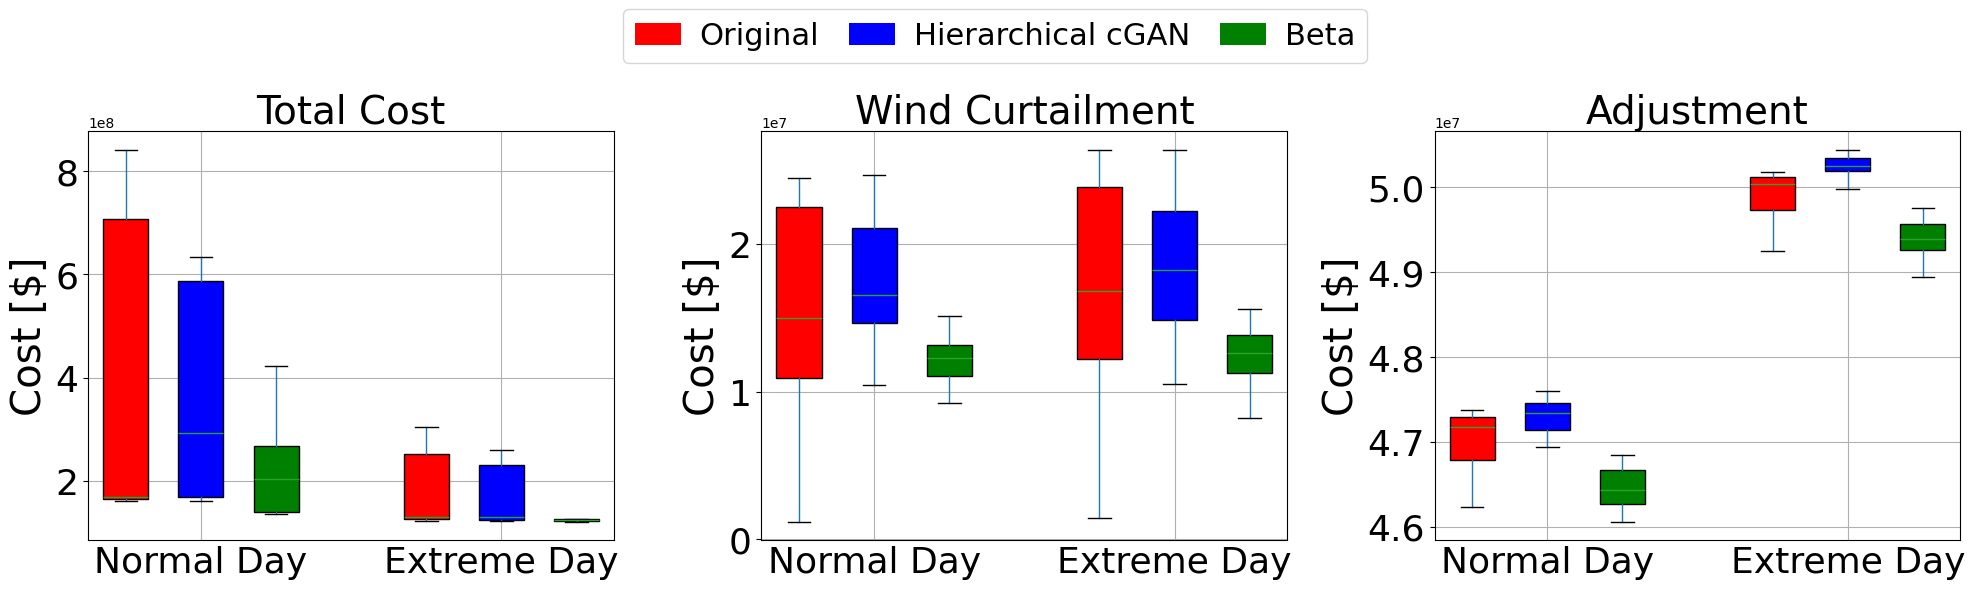

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch



df_normal_original = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/originalsgp62optimization_results.csv')
df_extreme_original = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/originalsgp52optimization_results.csv')
df_extreme_new = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/cganv7sgp52optimization_results.csv')
df_normal_new = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/cganv7sgp62optimization_results.csv')

#beta
df_normal_generated = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/betasgp62optimization_results.csv')
df_extreme_generated = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/betasgp52optimization_results.csv') 


# Settings
cost_types = ['realtime cost', 'total wind', 'Deviation Cost']
labels = ['Total Cost', 'Wind Curtailment', 'Adjustment']
colors = {
    'normal_original': 'red',
    'normal_new': 'blue',
    'normal_generated': 'green',
    'extreme_original': 'red',
    'extreme_new': 'blue',
    'extreme_generated': 'green'
}

# Settings
cost_types = ['realtime cost', 'total wind', 'Deviation Cost']
labels = ['Total Cost', 'Wind Curtailment', 'Adjustment']
colors = {
    'normal_original': 'red',
    'normal_new': 'blue',
    'normal_generated': 'green',
    'extreme_original': 'red',
    'extreme_new': 'blue',
    'extreme_generated': 'green'
}






# Create plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharex=False)

common = dict(patch_artist=True, widths=0.6, showfliers=False) 

for i, (cost, label) in enumerate(zip(cost_types, labels)):
    ax = axes[i]
    positions = [1, 2, 3, 5, 6, 7]

    # Normal day
    df_normal_original.boxplot(column=[cost], ax=ax, positions=[positions[0]],
                               boxprops=dict(facecolor=colors['normal_original']), **common)
    df_normal_new.boxplot(column=[cost], ax=ax, positions=[positions[1]],
                          boxprops=dict(facecolor=colors['normal_new']), **common)
    df_normal_generated.boxplot(column=[cost], ax=ax, positions=[positions[2]],
                                boxprops=dict(facecolor=colors['normal_generated']), **common)

    # Extreme day
    df_extreme_original.boxplot(column=[cost], ax=ax, positions=[positions[3]],
                                boxprops=dict(facecolor=colors['extreme_original']), **common)
    df_extreme_new.boxplot(column=[cost], ax=ax, positions=[positions[4]],
                           boxprops=dict(facecolor=colors['extreme_new']), **common)
    df_extreme_generated.boxplot(column=[cost], ax=ax, positions=[positions[5]],
                                 boxprops=dict(facecolor=colors['extreme_generated']), **common)

    # Formatting
    ax.set_title(label, fontsize=28)
    ax.set_xticks([2, 6])
    ax.set_xticklabels(['Normal Day', 'Extreme Day'], fontsize=26)
    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', labelsize=26)
    ax.grid(True)
    ax.set_ylabel('Cost [$]' if i < 3 else 'Price [$/MWh]', fontsize=29)


# Legend (outside, centered above)
legend_elements = [
    Patch(facecolor='red',  label='Original'),
    Patch(facecolor='blue', label='Hierarchical cGAN'),
    Patch(facecolor='green',label='Beta')
]
fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, 1),   
    ncol=3,
    fontsize=22,
    frameon=True,
    handlelength=1.5,
    handletextpad=0.6,
    columnspacing=1
)

plt.tight_layout(rect=[0, 0, 1, 0.86])   # shrink the area used by subplots
plt.show()


# Normal day (229) in June-August

In [ ]:
import io
import sys
import pandas as pd


results = []

for osw_day in [154, 159, 160, 162, 165, 166, 167, 168, 176, 181, 182, 184, 185, 186, 190, 191, 196, 197, 198, 199, 207, 208, 210, 212, 213, 215, 216, 217, 227, 228, 229, 230]:
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    # data preparation and settings
    day = 229  
    wind_series_day_ruw = {**wind_series_onsh[day], **wind_series_osw_ruw[osw_day]}
    wind_series_day_act = {**wind_series_onsh[day], **wind_series_osw_act[osw_day]}

    # set lines connecting osw
    osw_smax = 5000
    for l in lines.values():
        fzone = nodes[l["from"]]['Zone']
        tzone = nodes[l["to"]]['Zone']
        if fzone in osw_zones or tzone in osw_zones:
            l["s_max"] = max(l["s_max"], osw_smax)

    # other settings
    n_t = 24
    VOLL = 1e5
    curtailment_penalty = 100
    lf_scale = 1.
    gen_list = list(gens.keys())
    node_list = list(nodes.keys())
    line_list = list(lines.keys())
    t_list = [t for t in range(n_t)]
    n_gen = len(gens)
    n_node = len(nodes)
    n_line = len(lines)

    # Build and run uc
    m_uc, gencost_uc, _, load_shedding, wind_curtailment = build_uc_problem(load_series[day], wind_series_day_ruw, solar_series[day])
    m_uc.optimize()

    fixed = m_uc.fixed()
    fixed.optimize()
    status_str = {
    GRB.OPTIMAL: "Optimal",
    GRB.INFEASIBLE: "Infeasible",
    GRB.UNBOUNDED: "Unbounded",
    GRB.INF_OR_UNBD: "Infeasible or Unbounded",
    GRB.TIME_LIMIT: "Time Limit Reached",
    }.get(fixed.Status, f"Status Code {fixed.Status}")

    print(f"Pricing run finished: {status_str}")
    lambda_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = fixed.getConstrByName(f'lambda[({i},{t})]')
            lambda_dict[(i,t)] = const.getAttr("Pi") 

    

    # Collect UC results
    uc_results = {
        'Day': osw_day,
        'Phase': 'UC',
        'Wind Curtailment Cost_uc': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_uc.ObjVal,
        "average price_da " : np.mean([np.mean([lambda_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(uc_results)

    # Re-run RT
    m_rt, gencost_rt, redcost, load_shedding, wind_curtailment = build_rt_problem(load_series[day], wind_series_day_act, solar_series[day])
    m_rt.optimize()

    lambda_rt_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = m_rt.getConstrByName(f'lambda[({i},{t})]')
            lambda_rt_dict[(i,t)] = const.getAttr("Pi")

    # Collect RT results
    rt_results = {
        'Day': osw_day,
        'Phase': 'RT',
        'Wind Curtailment Cost_rt': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_rt.ObjVal,
        'Deviation Cost': sum([redcost[t].getValue() for t in t_list]),
        "total obj" : m_rt.ObjVal+ m_uc.ObjVal,
        "average price_rt " : np.mean([np.mean([lambda_rt_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(rt_results)

    sys.stdout = old_stdout
    new_stdout.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('cganv7sgpu112optimization_results.csv', index=False)

print("Results saved to 'optimization_results.csv'")


# Extreme day (235) in June-August

In [ ]:
import io
import sys
import pandas as pd


results = []

for osw_day in [154, 159, 160, 162, 165, 166, 167, 168, 176, 181, 182, 184, 185, 186, 190, 191, 196, 197, 198, 199, 207, 208, 210, 212, 213, 215, 216, 217, 227, 228]:
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    # data preparation and settings
    day = 235 
    wind_series_day_ruw = {**wind_series_onsh[day], **wind_series_osw_ruw[osw_day]}
    wind_series_day_act = {**wind_series_onsh[day], **wind_series_osw_act[osw_day]}

    # set lines connecting osw
    osw_smax = 5000
    for l in lines.values():
        fzone = nodes[l["from"]]['Zone']
        tzone = nodes[l["to"]]['Zone']
        if fzone in osw_zones or tzone in osw_zones:
            l["s_max"] = max(l["s_max"], osw_smax)

    # other settings
    n_t = 24
    VOLL = 1e5
    curtailment_penalty = 100
    lf_scale = 1.
    gen_list = list(gens.keys())
    node_list = list(nodes.keys())
    line_list = list(lines.keys())
    t_list = [t for t in range(n_t)]
    n_gen = len(gens)
    n_node = len(nodes)
    n_line = len(lines)

    # Build and run uc
    m_uc, gencost_uc, _, load_shedding, wind_curtailment = build_uc_problem(load_series[day], wind_series_day_ruw, solar_series[day])
    m_uc.optimize()

    fixed = m_uc.fixed()
    fixed.optimize()
    status_str = {
    GRB.OPTIMAL: "Optimal",
    GRB.INFEASIBLE: "Infeasible",
    GRB.UNBOUNDED: "Unbounded",
    GRB.INF_OR_UNBD: "Infeasible or Unbounded",
    GRB.TIME_LIMIT: "Time Limit Reached",
    }.get(fixed.Status, f"Status Code {fixed.Status}")

    print(f"Pricing run finished: {status_str}")
    lambda_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = fixed.getConstrByName(f'lambda[({i},{t})]')
            lambda_dict[(i,t)] = const.getAttr("Pi") 

    

    # Collect UC results
    uc_results = {
        'Day': osw_day,
        'Phase': 'UC',
        'Wind Curtailment Cost_uc': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_uc.ObjVal,
        "average price_da " : np.mean([np.mean([lambda_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(uc_results)

    # Re-run RT
    m_rt, gencost_rt, redcost, load_shedding, wind_curtailment = build_rt_problem(load_series[day], wind_series_day_act, solar_series[day])
    m_rt.optimize()

    lambda_rt_dict = {}
    for t in range(n_t):
        for i in node_list:
            const = m_rt.getConstrByName(f'lambda[({i},{t})]')
            lambda_rt_dict[(i,t)] = const.getAttr("Pi")

    # Collect RT results
    rt_results = {
        'Day': osw_day,
        'Phase': 'RT',
        'Wind Curtailment Cost_rt': sum([wind_curtailment[t].getValue() for t in t_list]) * curtailment_penalty,
        'Objective Value': m_rt.ObjVal,
        'Deviation Cost': sum([redcost[t].getValue() for t in t_list]),
        "total obj" : m_rt.ObjVal+ m_uc.ObjVal,
        "average price_rt " : np.mean([np.mean([lambda_rt_dict[i,t] for i in node_list if lambda_dict[i,t] <= pcut]) for t in range(n_t)]),
    }
    results.append(rt_results)

    sys.stdout = old_stdout
    new_stdout.close()

results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('cganv7sgpu122optimization_results.csv', index=False)

print("Results saved to 'optimization_results.csv'")


# box-plot

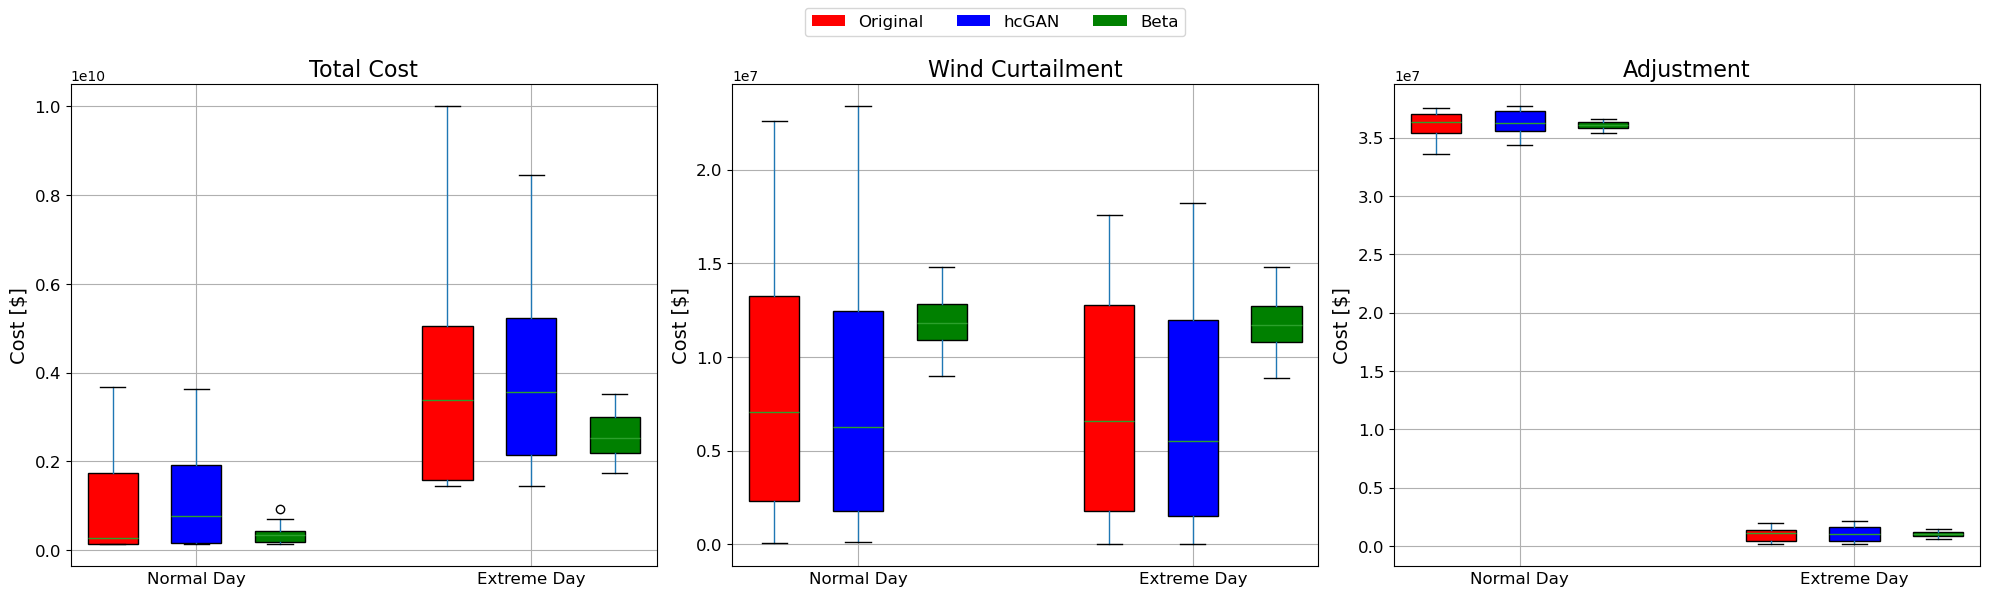

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch



df_normal_original = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/originalsgpu112optimization_results.csv')
df_extreme_original = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/originalsgpu122optimization_results.csv')
df_extreme_new = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/cganv7sgpu122optimization_results.csv')
df_normal_new = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/cganv7sgpu112optimization_results.csv')

#beta
df_normal_generated = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/betasgpu112optimization_results.csv')
df_extreme_generated = pd.read_csv('/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/RUCOOL_ANALYSIS_PROJECT_APRIL_2025/Scenario-based UC/betasgpu122optimization_results.csv') 





# Settings
cost_types = ['realtime cost', 'total wind', 'Deviation Cost']
labels = ['Total Cost', 'Wind Curtailment', 'Adjustment']
colors = {
    'normal_original': 'red',
    'normal_new': 'blue',
    'normal_generated': 'green',
    'extreme_original': 'red',
    'extreme_new': 'blue',
    'extreme_generated': 'green'
}

# Settings
cost_types = ['realtime cost', 'total wind', 'Deviation Cost']
labels = ['Total Cost', 'Wind Curtailment', 'Adjustment']
colors = {
    'normal_original': 'red',
    'normal_new': 'blue',
    'normal_generated': 'green',
    'extreme_original': 'red',
    'extreme_new': 'blue',
    'extreme_generated': 'green'
}

# Create plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharex=False)

for i, (cost, label) in enumerate(zip(cost_types, labels)):
    ax = axes[i]
    positions = [1, 2, 3, 5, 6, 7]  
    # Normal day
    df_normal_original.boxplot(column=[cost], ax=ax, positions=[positions[0]],
                               patch_artist=True, widths=0.6,
                               boxprops=dict(facecolor=colors['normal_original']))
    df_normal_new.boxplot(column=[cost], ax=ax, positions=[positions[1]],
                          patch_artist=True, widths=0.6,
                          boxprops=dict(facecolor=colors['normal_new']))
    df_normal_generated.boxplot(column=[cost], ax=ax, positions=[positions[2]],
                                 patch_artist=True, widths=0.6,
                                 boxprops=dict(facecolor=colors['normal_generated']))

    # Extreme day
    df_extreme_original.boxplot(column=[cost], ax=ax, positions=[positions[3]],
                                 patch_artist=True, widths=0.6,
                                 boxprops=dict(facecolor=colors['extreme_original']))
    df_extreme_new.boxplot(column=[cost], ax=ax, positions=[positions[4]],
                            patch_artist=True, widths=0.6,
                            boxprops=dict(facecolor=colors['extreme_new']))
    df_extreme_generated.boxplot(column=[cost], ax=ax, positions=[positions[5]],
                                 patch_artist=True, widths=0.6,
                                 boxprops=dict(facecolor=colors['extreme_generated']))

    # Formatting
    ax.set_title(label, fontsize=16)
    ax.set_xticks([2, 6])
    ax.set_xticklabels(['Normal Day', 'Extreme Day'], fontsize=12)
    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True)
    ax.set_ylabel('Cost [$]' if i < 3 else 'Price [$/MWh]', fontsize=14)

# Add legend
legend_elements = [
    Patch(facecolor='red', label='Original'),
    Patch(facecolor='blue', label='hcGAN'),
    Patch(facecolor='green', label='Beta')
]

fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()